In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os
data_name = 'DentateGyrus'

Global seed set to 0


You need to change this to suitable directories on your system:

In [2]:
#  where to download data and where to save results
data_path = '/home/jupyter/data/benchmarking_datasets/DentateGyrus/'
results_path = '/home/jupyter/data/cell2fate_paper_results/DentateGyrus/'

In [3]:
# Downloading data into specified directory:
os.system('cd ' + data_path + ' && wget -q https://cell2fate.cog.sanger.ac.uk/' + data_name + '/' + data_name + '_anndata.h5ad')

0

Load the data and extract most variable genes (and optionally remove some clusters).

In [4]:
adata = sc.read_h5ad(data_path + data_name + '_anndata.h5ad')
background = adata.var_names
clusters_to_remove = [] 
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                    remove_clusters = clusters_to_remove,
                                min_shared_counts = 20, n_var_genes= 3000)

Keeping at most 100000 cells per cluster
Filtered out 10340 genes that are detected 20 counts (shared).
Extracted 3000 highly variable genes.


Overview of the dataset on a UMAP, coloured by cluster assingment.

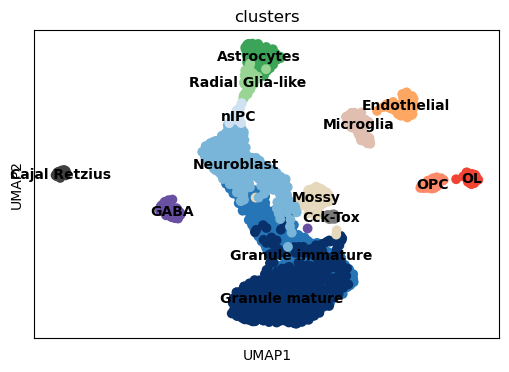

In [5]:
fig, ax = plt.subplots(1,1, figsize = (6, 4))
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data', show = False, ax = ax)
plt.savefig(results_path + data_name + 'UMAP_clusters.pdf')

As usual in the scvi-tools workflow we register the anndata object ...

In [6]:
c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label='spliced', unspliced_label='unspliced')

... and initialize the model:

In [7]:
max_modules = c2f.utils.get_max_modules(adata)
mod = c2f.Cell2fate_DynamicalModel(adata, n_modules = max_modules)

Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.
Number of Leiden Clusters: 14
Maximal Number of Modules: 16


Let's have a look at the anndata setup:

In [8]:
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2fate_DynamicalModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'unspliced_label': 'unspliced',
│   'spliced_label': 'spliced',
│   'cluster_label': None
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 2930  │
│      n_vars      │ 3000  │
│     n_batch      │   1   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  unspliced   │ adata.layers['unspliced'] │
│   spliced    │  adata.layers['spliced']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

Training the model:

In [9]:
mod.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [15:52<00:00,  1.91s/it, v_num=1, elbo_train=6.75e+6]


We plot training history over multiple windows to effectively assess convergence (which is not reached here but it is close.)

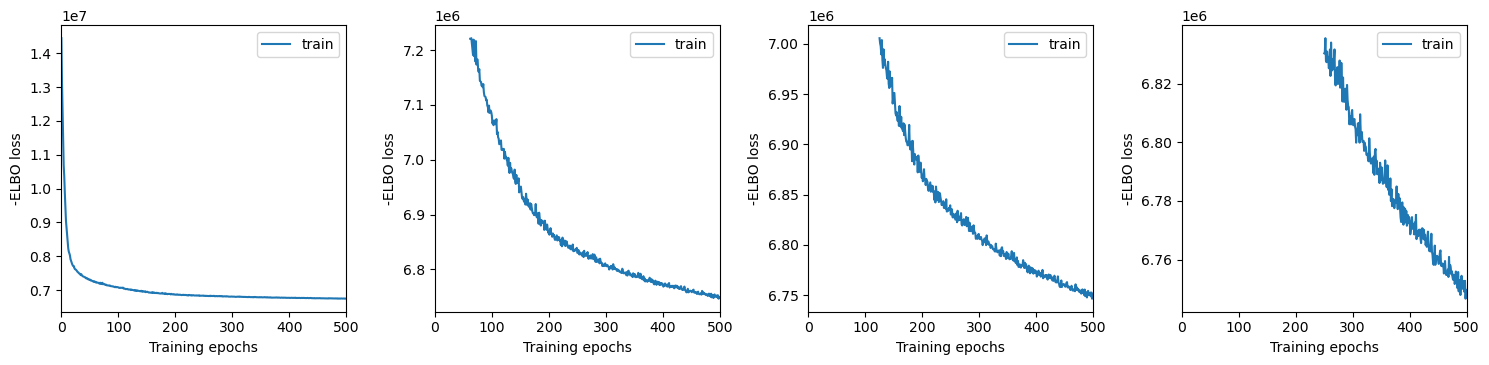

In [10]:
mod.view_history()

Here we export the model posterior to the anndata object:

In [11]:
adata = mod.export_posterior(adata)

sample_kwargs['batch_size'] 2930
Sampling global variables, sample: 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]


One of the interesting parameter posteriors that was saved to the anndata object is the differentiation time:

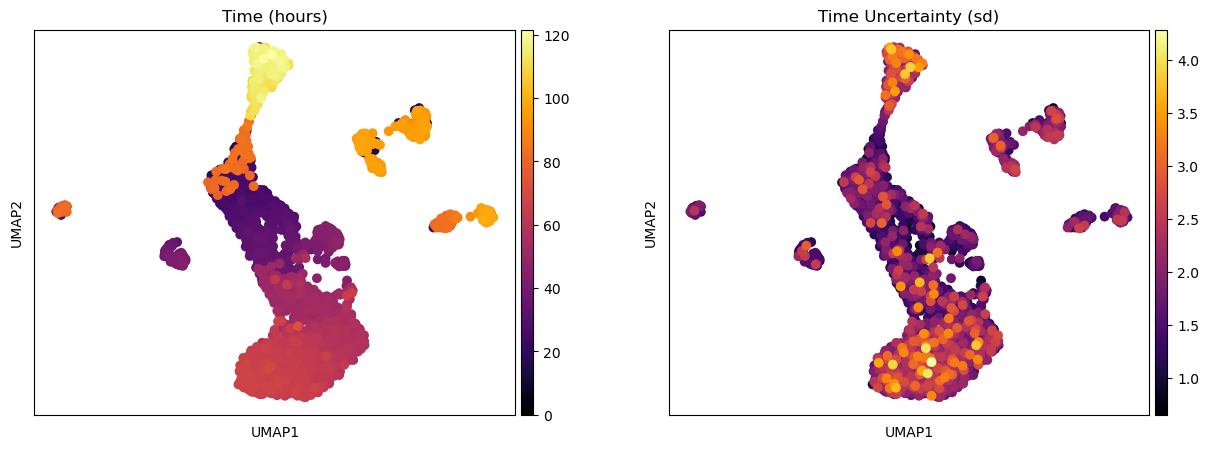

In [12]:
fig, ax = plt.subplots(1,2, figsize = (15, 5))
sc.pl.umap(adata, color = ['Time (hours)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[0])
sc.pl.umap(adata, color = ['Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2, show = False, ax = ax[1])
plt.savefig(results_path + data_name + 'UMAP_Time.pdf')

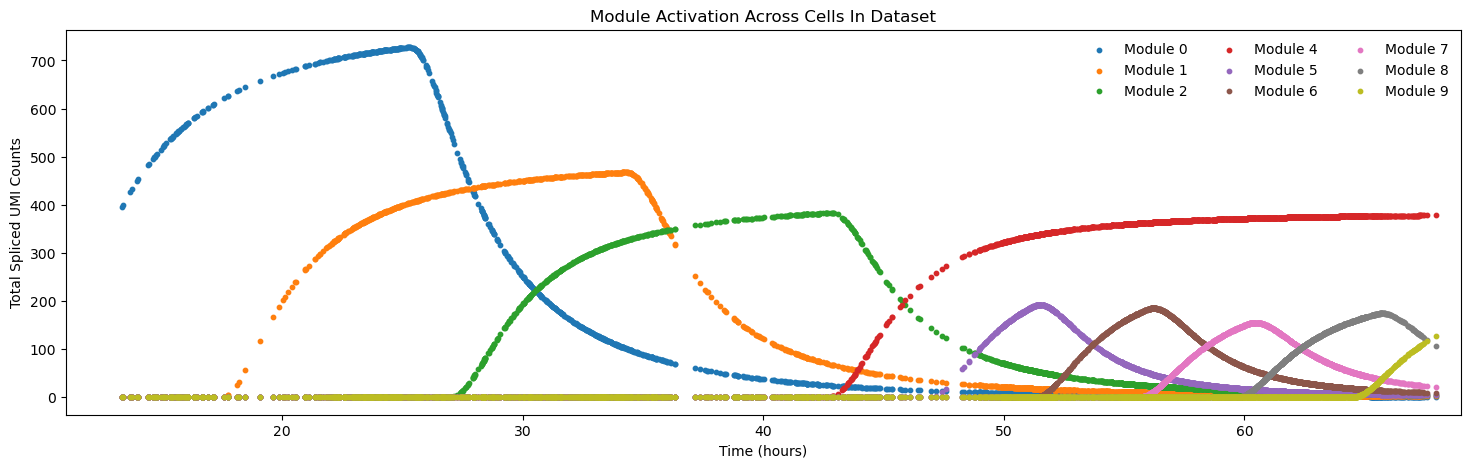

In [13]:
mod.compare_module_activation(adata, chosen_modules = [0,1,2,4,5,6,7,8,9], time_min = 11, time_max = 69,
                         save = results_path + data_name + 'module_activation_comparison.pdf', ncol = 3)

In [14]:
# import scipy
# import torch
# from cell2fate.utils import mu_mRNA_continousAlpha_globalTime_twoStates

# def compute_module_summary_statistics(self, adata):
#     '''Computes the contribution of each module to mRNA molecules in each cell'''
#     if scipy.sparse.issparse(self.adata_manager.get_from_registry('unspliced')):
#         observed_total = torch.sum(torch.sum(torch.stack([torch.tensor(self.adata_manager.get_from_registry('unspliced').toarray()),
#                       torch.tensor(self.adata_manager.get_from_registry('spliced').toarray())], axis = -1), axis = -1), axis = -1)
#     else:
#         observed_total = torch.sum(torch.sum(torch.stack([torch.tensor(self.adata_manager.get_from_registry('unspliced')),
#                       torch.tensor(self.adata_manager.get_from_registry('spliced'))], axis = -1), axis = -1), axis = -1)
#     inferred_total = torch.sum(torch.sum(torch.tensor(self.samples['post_sample_means']['mu_expression']), axis = -1), axis = -1)
#     for m in range(self.module.model.n_modules):
#         mu_m = mu_mRNA_continousAlpha_globalTime_twoStates(
#             torch.tensor(self.samples['post_sample_means']['A_mgON'][m,:]),
#             torch.tensor(0.),
#             torch.tensor(self.samples['post_sample_means']['beta_g']),
#             torch.tensor(self.samples['post_sample_means']['gamma_g']),
#             torch.tensor(self.samples['post_sample_means']['lam_mi'][m,:]),
#             torch.tensor(self.samples['post_sample_means']['T_c'][:,:,0]),
#             torch.tensor(self.samples['post_sample_means']['T_mON'][:,:,m]),
#             torch.tensor(self.samples['post_sample_means']['T_mOFF'][:,:,m]),
#             torch.zeros((self.module.model.n_obs, self.module.model.n_vars)))
#         ss_total = torch.sum(torch.tensor(self.samples['post_sample_means']['A_mgON'][m,:])/torch.tensor(self.samples['post_sample_means']['gamma_g']) + \
#     torch.tensor(self.samples['post_sample_means']['A_mgON'][m,:])/torch.tensor(self.samples['post_sample_means']['beta_g']), axis = 1)
#         adata.obs['Module ' + str(m) + ' Activation'] = torch.sum(torch.sum(mu_m, axis = -1), axis = -1)/ss_total
#         adata.obs['Module ' + str(m) + ' State'] = 'OFF'
#         adata.obs['Module ' + str(m) + ' State'
#          ][self.samples['post_sample_means']['T_c'][:,0,0] > self.samples['post_sample_means']['T_mON'][0,0,m]
#           ] = 'Induction'
#         adata.obs['Module ' + str(m) + ' State'
#          ][self.samples['post_sample_means']['T_c'][:,0,0] > self.samples['post_sample_means']['T_mOFF'][0,0,m]
#           ] = 'Repression'
#         adata.obs['Module ' + str(m) + ' State'
#          ][adata.obs['Module ' + str(m) + ' Activation'] > 0.95
#           ] = 'ON'
#         adata.obs['Module ' + str(m) + ' State'
#          ][adata.obs['Module ' + str(m) + ' Activation'] < 0.05
#           ] = 'OFF'
#         adata.obs['Module ' + str(m) + ' Activation'] = torch.sum(torch.sum(mu_m, axis = -1), axis = -1)
#     return adata

In [15]:
# def plot_module_summary_statistics(self, adata, save = None):
#     'Weight, Activation, Velocity, Switch ON/OFF time (histogram)'
#     limit = np.max([np.sort(adata.obs['Module ' + str(i) + ' Activation'])[int(np.round(0.99*len(adata.obs['Module ' + str(i) + ' Activation'])))] for i in range(self.module.model.n_modules)])
#     fig, ax = plt.subplots(self.module.model.n_modules, 2, figsize = (10, 4*self.module.model.n_modules))
#     for i in range(self.module.model.n_modules):
#         sc.pl.umap(adata, color = ['Module ' + str(i) + ' Activation'], legend_loc = None,
#                     size = 200, color_map = 'viridis', ax = ax[i,0], show = False, vmin = 0, vmax = limit)
#         sc.pl.umap(adata, color = ['Module ' + str(i) + ' State'], legend_loc = 'on data',
#                     size = 200, ax = ax[i,1], show = False,
#                    palette =  {'ON': 'lime', 'OFF': 'grey', 'Induction': 'lightgreen', 'Repression': 'orange'})
#         plt.tight_layout()
#     if save:
#         plt.savefig(save)

In [16]:
# adata = compute_module_summary_statistics(mod, adata)

In [17]:
# plot_module_summary_statistics(mod, adata)

We can compute some module statistics to visualize the activity of the underlying modules:

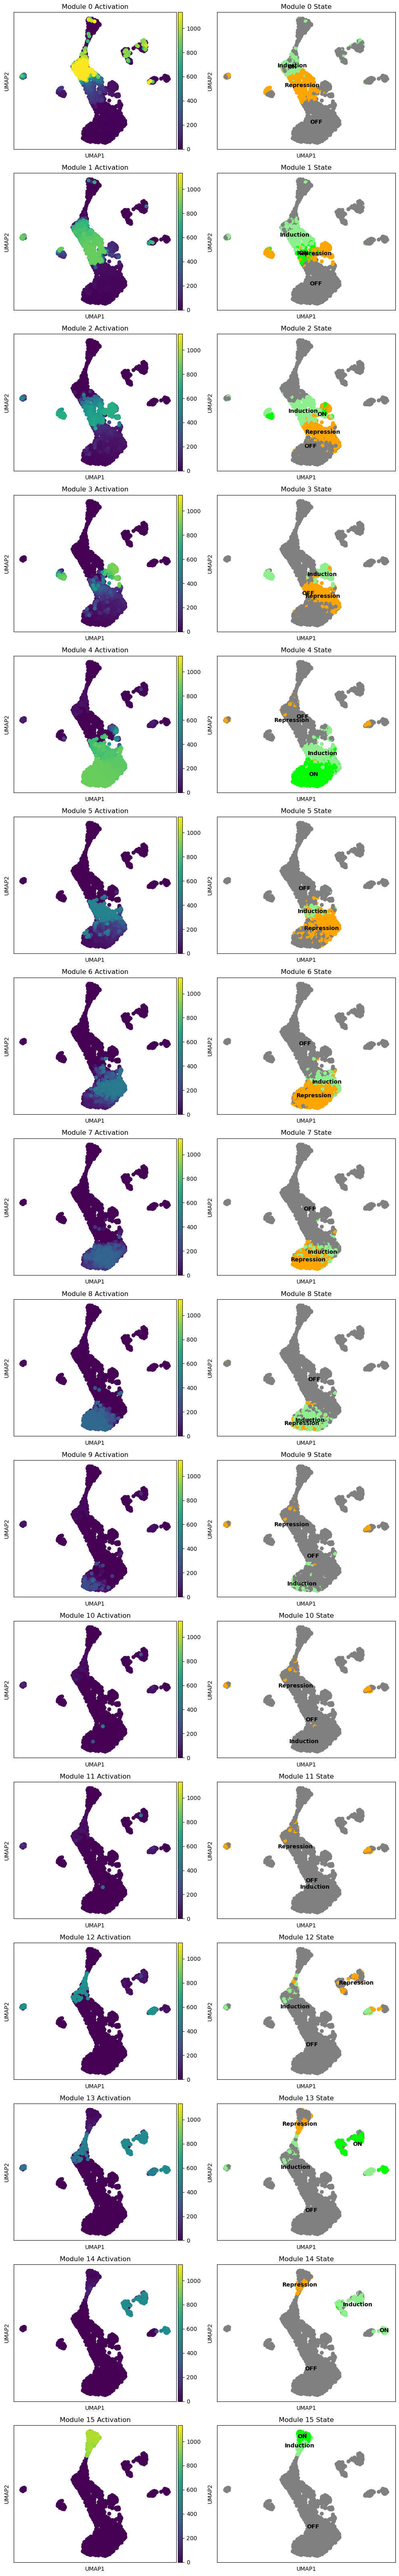

In [18]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata, save = results_path + data_name + 'module_summary_stats_plot.pdf')

This plot explains how we get module states from the module activation (see figure 3b in the paper):

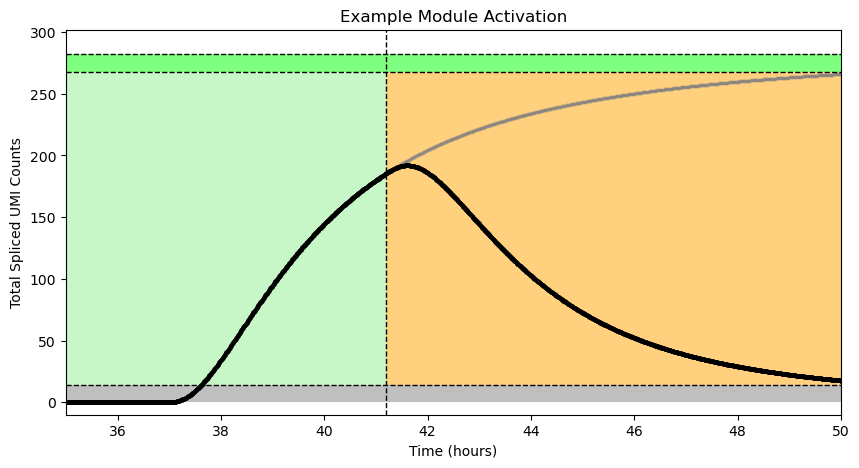

In [19]:
mod.example_module_activation(adata, chosen_module = 5, time_min = 35, time_max = 50,
                         save = results_path + data_name + 'module_activation_example.pdf')

It is also possible to visualize "module-specific" velocity although this does not always work well:

In [20]:
# mod.compute_and_plot_module_velocity(adata, save = results_path + data_name + 'module_velocity_plots.png', 
#                                     plotting_kwargs = {"color": 'clusters', 'legend_fontsize': 10,
#                                                         'legend_loc': 'right_column', 'min_mass': 4.4})

And of course we can make the usual visualization of total RNAvelocity on a UMAP:

Computing total RNAvelocity ...


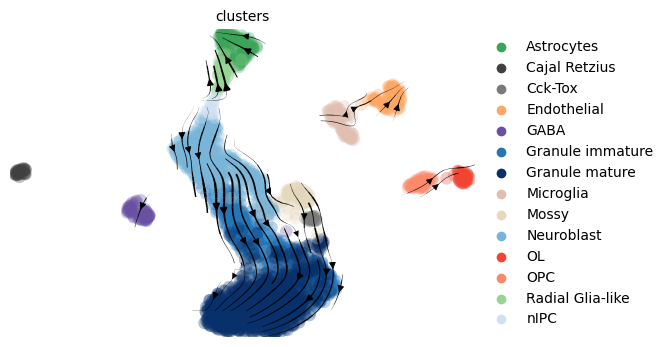

In [21]:
mod.compute_and_plot_total_velocity(adata, save = results_path + data_name + 'total_velocity_plots.png')

This visualization is more similar to the scvelo plots:

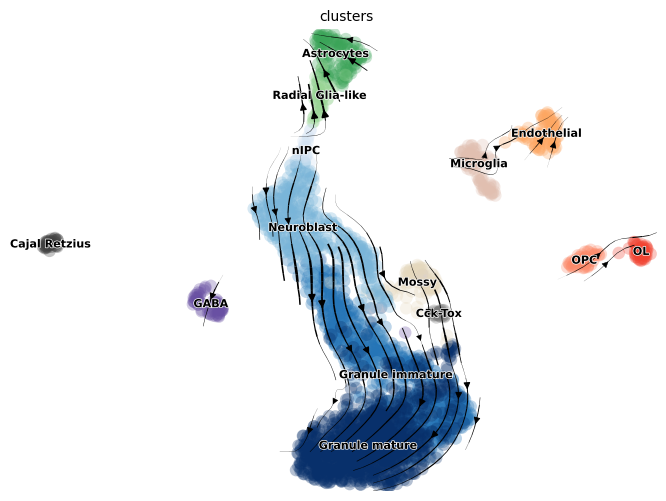

In [22]:
import scvelo as scv
fix, ax = plt.subplots(1, 1, figsize = (8, 6))
scv.pl.velocity_embedding_stream(adata, basis='umap', save = False, vkey='Velocity',
                                 show = False, ax = ax,legend_fontsize = 8)
plt.savefig(results_path + data_name + 'total_velocity_plots.png')

Technical variables usually show lower detection efficiency and higher noise (= lower overdispersion parameter) for unspliced counts:

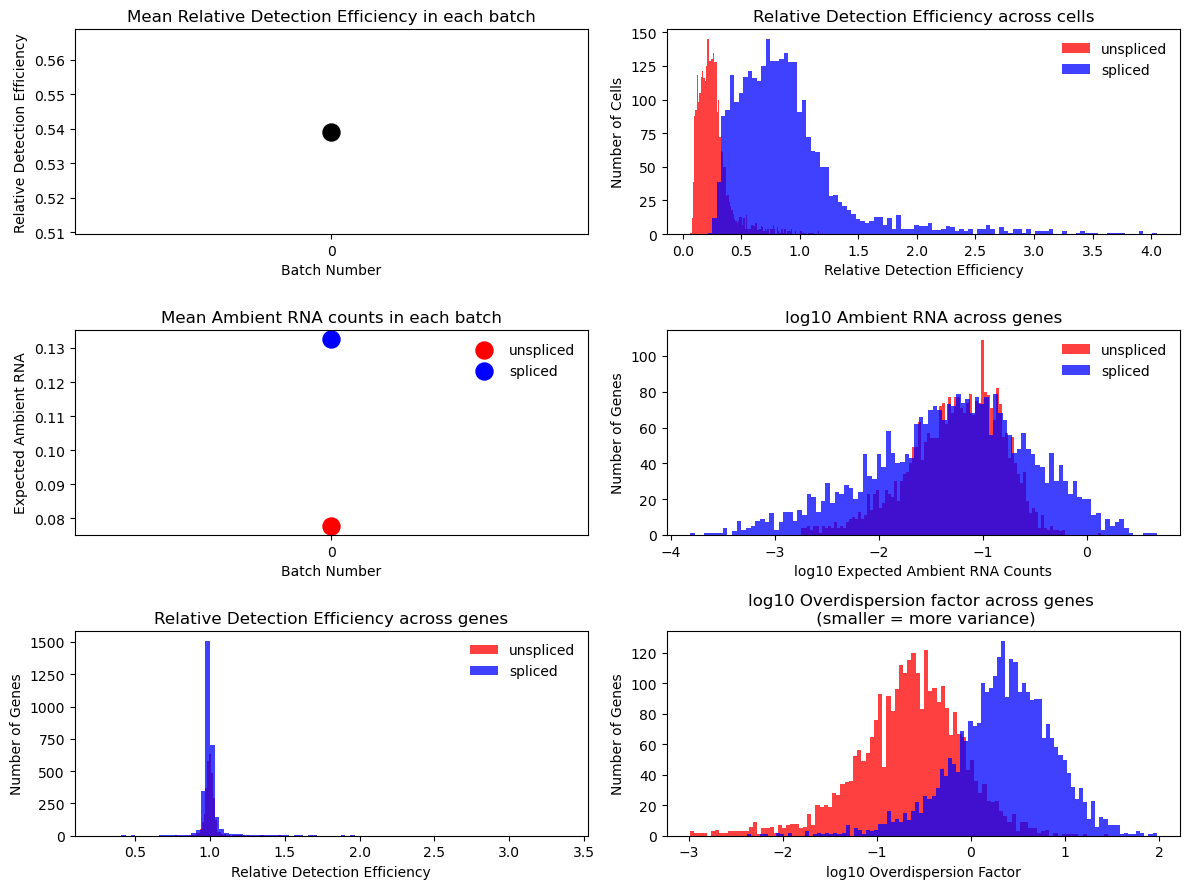

In [23]:
mod.plot_technical_variables(adata, save = results_path + data_name + 'technical_variables_overview_plot.pdf')

This is how to have a look at the various rate parameters the optimization converged to:

In [24]:
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

A_mgON mean: 0.070882834
gamma_g mean: 0.800978
beta_g mean: 1.2001703
lam_mi, all modules: 
 
 [[[3.88 3.19]]

 [[4.24 3.49]]

 [[3.2  3.39]]

 [[4.53 3.49]]

 [[2.15 2.45]]

 [[3.93 3.58]]

 [[3.85 3.32]]

 [[3.7  3.23]]

 [[5.   3.11]]

 [[4.47 3.73]]

 [[4.67 4.74]]

 [[5.17 2.86]]

 [[4.65 4.49]]

 [[4.18 4.65]]

 [[2.56 3.07]]

 [[2.5  3.17]]]


This method returns orders the genes and TFs in each module from most to least enriched. And it also performs gene set enrichment analysis:

In [25]:
tab, all_results = mod.get_module_top_features(adata, background, p_adj_cutoff=0.05, n_top_genes = 10)
tab.to_csv(results_path + data_name + 'module_top_features_table.csv')

"tab" contains a concise summary and "all_results" a list with detailed enrichment scores for all modules: 

In [26]:
tab

,Module Number,Genes Ranked,TFs Ranked,Terms Ranked
0,0,"Gal, Rgs6, Fbl, Pcdh15, Npm3, Rpl39, Cct8, Tri...","Nono, Rcor2, Smarcc1, Ezh2, Zfp410, Fos, Klf7,...",positive regulation of protein localization to...
1,1,"Rwdd1, Psma4, Ppa1, Skp1a, Ndufb6, Tm2d1, Emc4...","Nr4a2, Camta1, Zfp397, Cebpz, Zfp704, Ybx1, Ml...",
2,2,"Npy, Gad2, Npas1, Gad1, Psmb10, Gria4, Gap43, ...","Npas1, Arnt2, Klf7, Deaf1, Zfp706, Mllt11, Tax...",gamma-aminobutyric acid metabolic process (GO:...
3,3,"Gng4, B3gat3, Brinp2, Megf8, Tshz2, Satb1, Mgr...","Tshz2, Satb1, Kat5, Nr2f2, Thrb, Deaf1, Zmat4,...",heparan sulfate proteoglycan metabolic process...
4,4,"Pds5b, Rbm24, Aagab, Foxo1, Sptb, Fam19a1, Fam...","Foxo1, Atf6, Atf6b, Nfx1, Arid5b, Zc3h13, Zfp1...",cellular response to DNA damage stimulus (GO:0...
5,5,"Dgkh, Palm2, Ptprj, Larp1b, Pdzd2, Usp19, Ppp6...","Parp1, Rbm22, Rfx3, Zfp106, Zbtb37, Dnajc21, B...",negative regulation of cell motility (GO:20001...
6,6,"Fst, Rapgef5, Moxd1, Nup88, Stard13, Adarb2, S...","Zbtb16, Zmat4, Prdm5, Parp1, Ncoa2, Hmbox1, Ph...",regulation of cellular response to heat (GO:19...
7,7,"Kdm5d, Prr16, Akr1e1, Swt1, Rpa3, Figf, Dpagt1...","Kdm5d, Tfam, Zfp511, Prdm5, Zfp12, Mynn, Zfp9,...","axo-dendritic transport (GO:0008088), dolichyl..."
8,8,"Nudt13, Rgs2, Hscb, Numa1, 1700048O20Rik, Tnnt...","Nr4a2, Irf9, Mynn, Tfam, Kdm5a, Zfp414, Zfp292...",positive regulation of cardiac muscle contract...
9,9,"Coq3, Nup160, Sugp1, Smurf2, Ankrd26, Sdccag8,...","Nr4a2, Arnt, Zfp12, Zfp511, Tfam, Mynn, Kdm5a,...",positive regulation of protein metabolic proce...


In [27]:
all_results[9]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,positive regulation of protein metabolic proce...,3/115,0.000022,0.004920,0,0,76.063776,817.214231,SMURF2;IL18;INHBA
1,GO_Biological_Process_2021,positive regulation of reproductive process (G...,2/35,0.000133,0.015128,0,0,151.189394,1349.727435,SMURF2;INHBA
2,GO_Biological_Process_2021,positive regulation of multicellular organisma...,3/345,0.000558,0.034648,0,0,24.621554,184.441905,SMURF2;IL18;INHBA
3,GO_Biological_Process_2021,regulation of interferon-gamma production (GO:...,2/86,0.000804,0.034648,0,0,59.244048,422.155178,IL18;INHBA
4,GO_Biological_Process_2021,regulation of phosphorylation (GO:0042325),2/125,0.001688,0.034648,0,0,40.380081,257.806750,INHBA;NUP160
...,...,...,...,...,...,...,...,...,...,...
72,GO_Biological_Process_2021,regulation of interleukin-17 production (GO:00...,1/33,0.016382,0.049965,0,0,69.298611,284.928150,IL18
73,GO_Biological_Process_2021,protein modification by small protein conjugat...,2/409,0.016841,0.049965,0,0,12.028870,49.125003,SMURF2;NUP160
74,GO_Biological_Process_2021,regulation of activated T cell proliferation (...,1/34,0.016874,0.049965,0,0,67.195286,274.289235,IL18
75,GO_Biological_Process_2021,tRNA export from nucleus (GO:0006409),1/34,0.016874,0.049965,0,0,67.195286,274.289235,NUP160


We can plot top marker genes:

In [ ]:
mod.plot_top_features(adata, tab, chosen_modules = [0,1,2,4,5,6,7,8,9], mode = 'all genes', n_top_features = 7, process = True,
                      save = results_path + data_name + 'top_genes_plot.pdf')

Reprocessing adata.X, set process = False if this is not desired.


... as well as the top TFs for each module:

In [ ]:
mod.plot_top_features(adata, tab, chosen_modules =  [0,1,2,4,5,6,7,8,9], mode = 'TFs', n_top_features = 7, process = True,
                      save = results_path + data_name + 'top_TFs_plot.pdf')

This is another plotting functions to show marker genes and summary statistics for each module in a convenient format:

In [ ]:
# def plot_module_summary_statistics_2(self, adata, chosen_modules, chosen_clusters,
#                                  marker_genes, marker_TFs, cluster_key = 'clusters', save = None):
#     'tbd'
#     limit = np.max([np.sort(adata.obs['Module ' + str(i) + ' Activation'])[int(np.round(0.99*len(adata.obs['Module ' + str(i) + ' Activation'])))]
#                     for i in chosen_modules])
#     adata.X = adata.layers['unspliced'] + adata.layers['spliced']
#     sc.pp.normalize_total(adata, target_sum=1e4)
#     sc.pp.log1p(adata)
#     sc.pp.scale(adata, max_value=10)
#     plt.rcParams.update({'font.size': 14})
#     subset = np.array([c in chosen_clusters for c in adata.obs[cluster_key]])
#     plt.scatter(1, 1, label='Induction', s = 100, c='lightgreen')
#     plt.scatter(1, 1, label='ON', s = 100, c='lime')
#     plt.scatter(1, 1, label='Repression', s = 100, c='orange')
#     plt.scatter(1, 1, label='OFF', s = 100, c='grey')
#     plt.legend()
#     if save:
#         plt.savefig(save[:-4] + '_legend.pdf')
#     plt.show()
#     fig, ax = plt.subplots(4, len(chosen_modules), figsize = (3*len(chosen_modules), 20))
#     adata = adata[subset,:]
#     for i in range(len(chosen_modules)):
#         m = chosen_modules[i]
#         sc.pl.umap(adata, color = ['Module ' + str(m) + ' Activation'], legend_loc = None,
#                     size = 200, color_map = 'viridis', ax = ax[0,i], show = False, s = 300,
#                   vmin = 0, vmax = limit)
#         sc.pl.umap(adata, color = ['Module ' + str(m) + ' State'], 
#                     size = 200, ax = ax[1,i], show = False, legend_fontsize = 'x-large', s = 300, legend_loc = 'right_margin',
#                    palette = {'ON': 'lime', 'OFF': 'grey', 'Induction': 'lightgreen', 'Repression': 'orange'})
#         sc.pl.umap(adata, color = marker_genes[i], legend_loc = 'right margin',
#                         size = 200, show = False, ax = ax[2,i])
#         sc.pl.umap(adata, color = marker_TFs[i], legend_loc = 'right margin',
#                         size = 200, show = False, ax = ax[3,i])
#         plt.tight_layout()
#     if save:
#         plt.savefig(save)

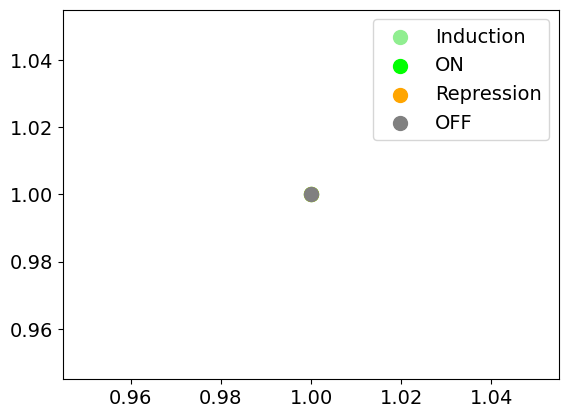

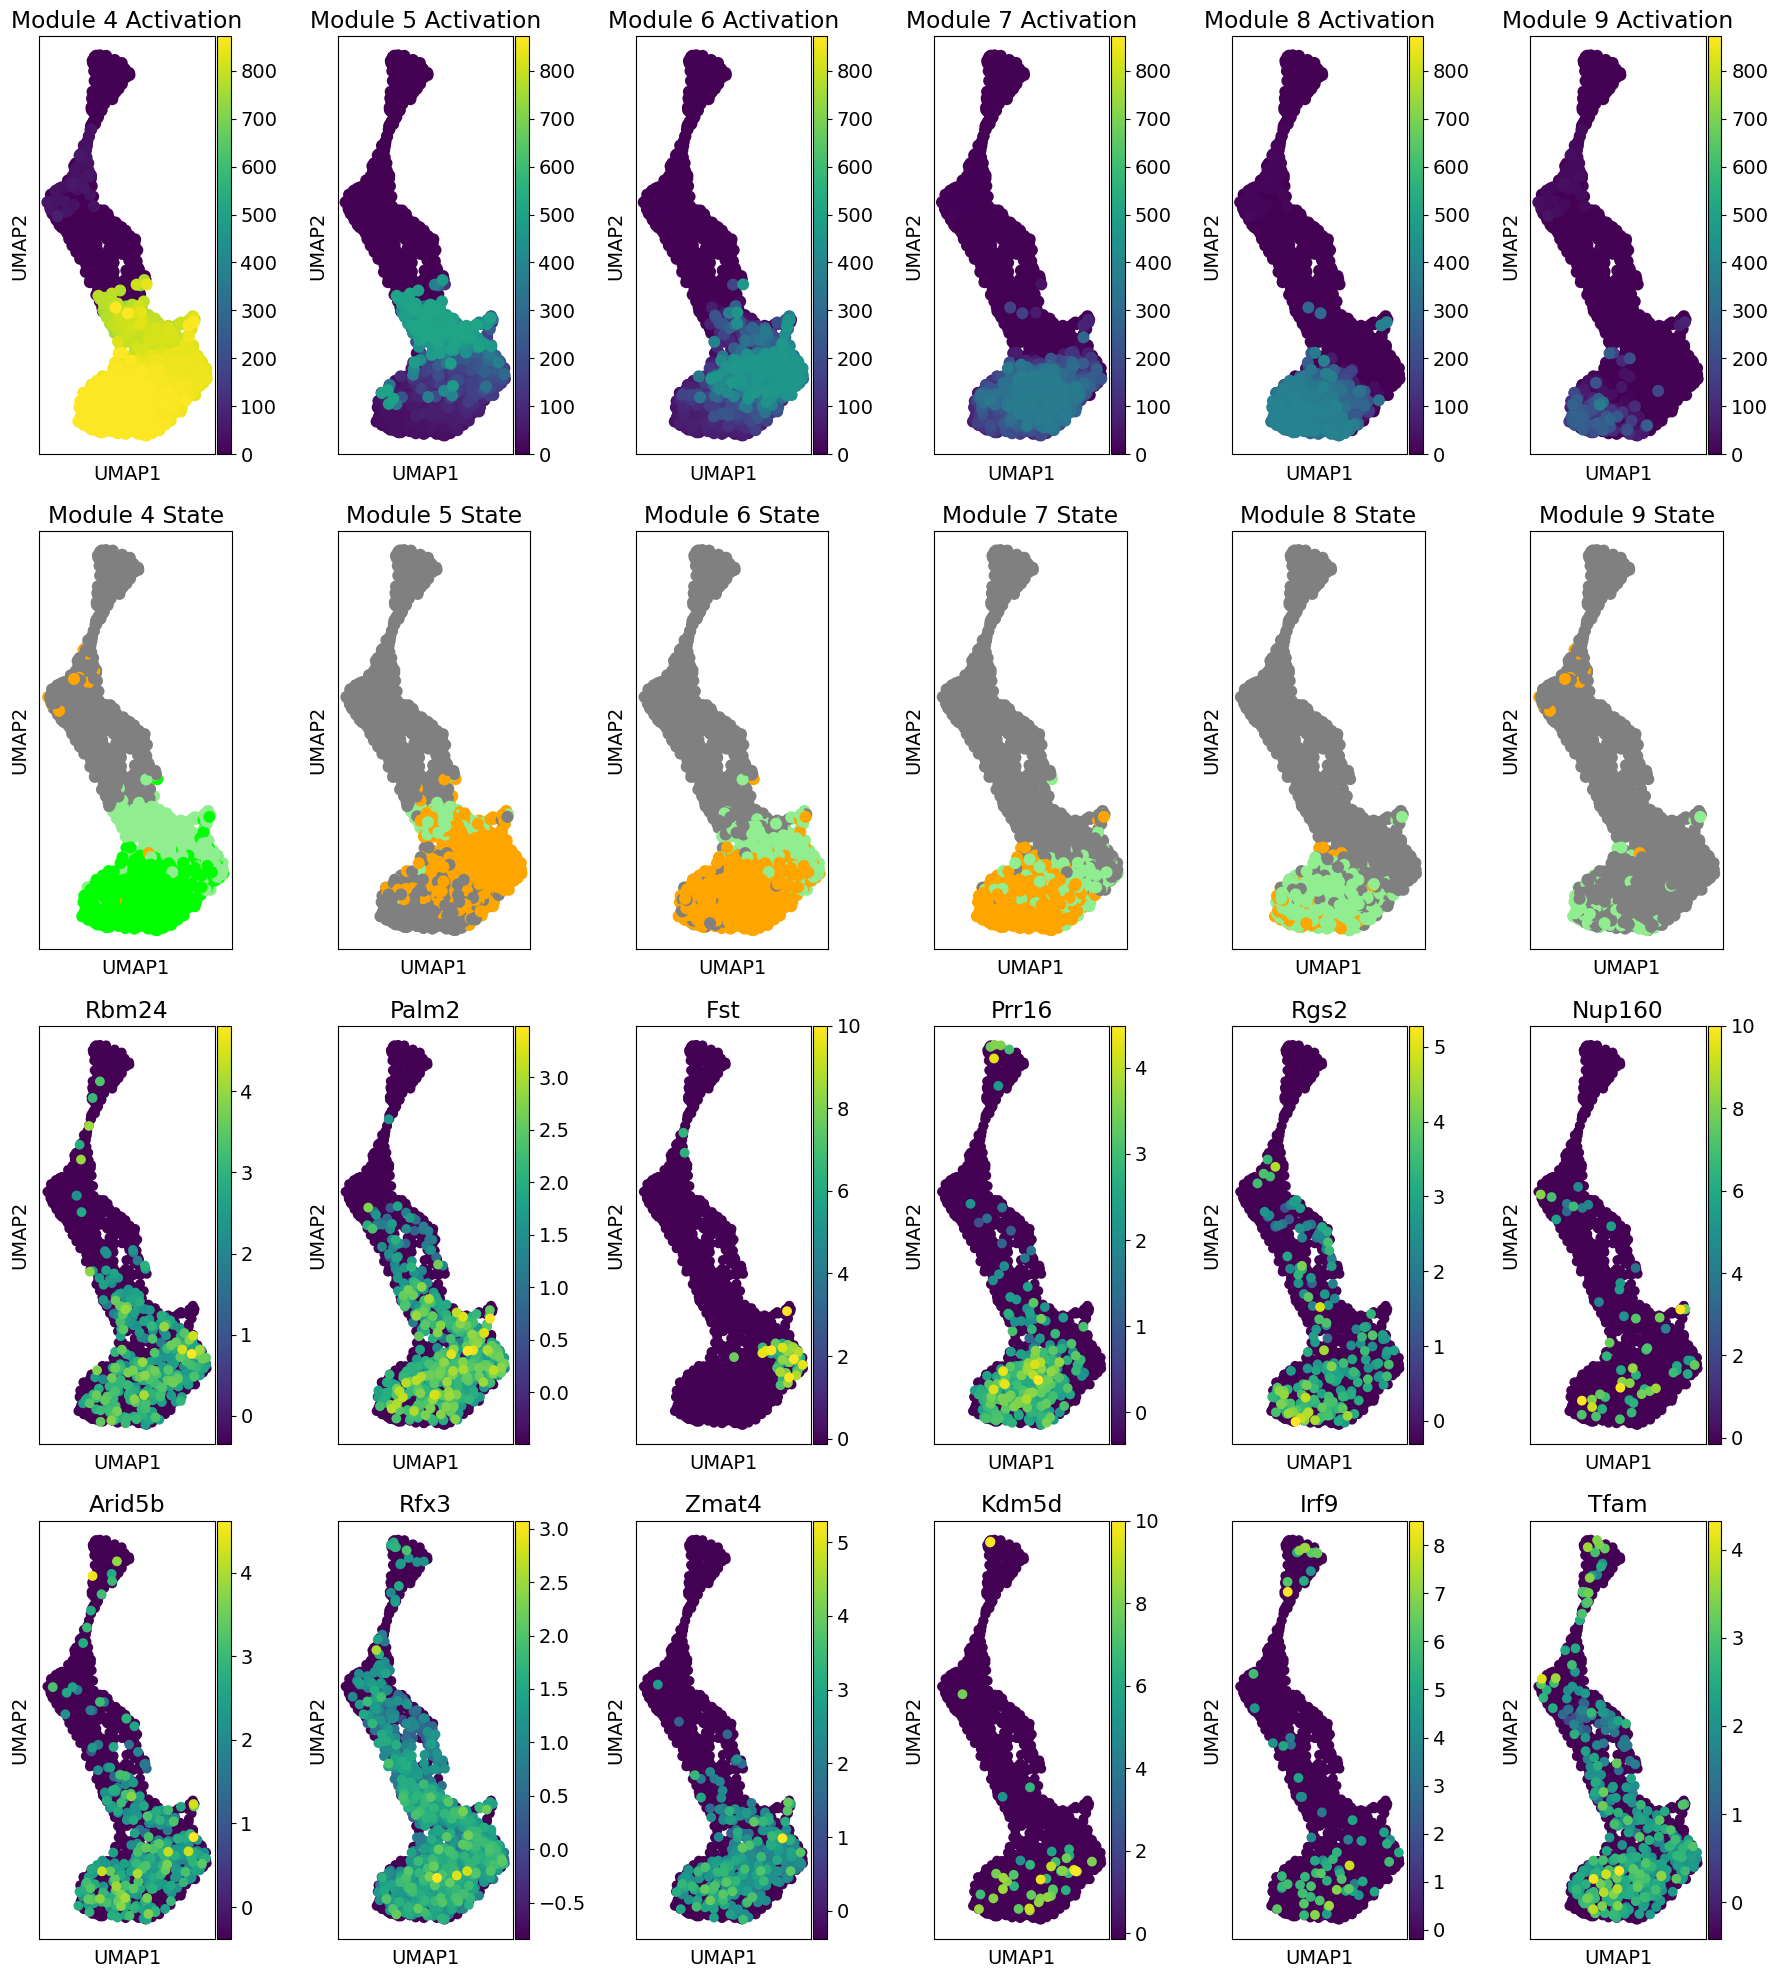

In [33]:
mod.plot_module_summary_statistics_2(adata,
                                 chosen_modules = [4,5,6,7,8,9],
                                 chosen_clusters = ['Radial Glia-like', 'Astrocytes', 'nIPC', 'Neuroblast',
                                                    'Granule immature', 'Granule mature'],
                                 marker_genes = ['Rbm24', 'Palm2',
                                    'Fst', 'Prr16', 'Rgs2', 'Nup160'],
                                 marker_TFs = ['Arid5b', 'Rfx3', 'Zmat4', 'Kdm5d', 'Irf9', 'Tfam'],
                                 save = results_path + data_name + 'module_overview_plot.pdf')

And for simply plotting selected genes we can use this function:

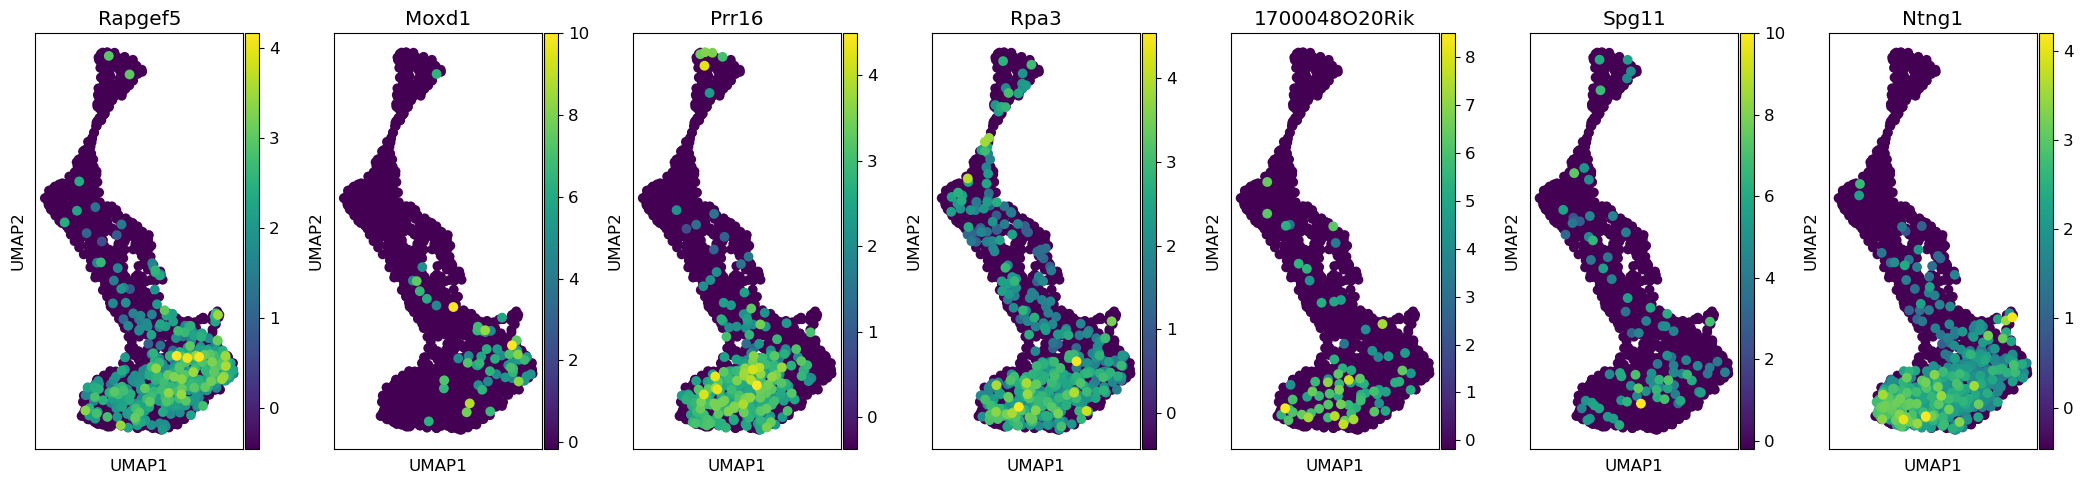

In [34]:
del adata.obsp
del adata.uns['Velocity_graph']
mod.plot_genes(adata,
           chosen_clusters = ['Radial Glia-like', 'Astrocytes', 'nIPC', 'Neuroblast',
                                                    'Granule immature', 'Granule mature'],
           marker_genes = ['Rapgef5', 'Moxd1', 'Prr16', 'Rpa3', '1700048O20Rik', 'Spg11', 'Ntng1'],
           save = results_path + data_name + 'additional_module_genes_plot.pdf')

##### 